<a href="https://colab.research.google.com/github/bangadpurva/NYT_News_Classification/blob/main/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import json
import time
import requests
import datetime
import dateutil
import pandas as pd
import re
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
pwd


'/content'

# New Section

In [ ]:
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
end = datetime.date.today()
start = end - relativedelta(years=1)
print(end, start)

2021-03-02 2020-03-02


In [ ]:
months_in_range = [x.split(' ') for x in pd.date_range(start, end, freq='MS').strftime("%Y %-m").tolist()]
print(months_in_range)

[['2020', '4'], ['2020', '5'], ['2020', '6'], ['2020', '7'], ['2020', '8'], ['2020', '9'], ['2020', '10'], ['2020', '11'], ['2020', '12'], ['2021', '1'], ['2021', '2'], ['2021', '3']]


In [ ]:
def send_request(date):
    '''Sends a request to the NYT Archive API for given date.'''
    base_url = 'https://api.nytimes.com/svc/archive/v1/'
    url = base_url  + date[0] + '/' + date[1] + '.json?api-key=' + 'WNG5DC1p1Eoz95qXkk8I0bDaBjeWvANn'
    response = requests.get(url).json()
    time.sleep(6)
    return response


def is_valid(article, date):
    '''An article is only worth checking if it is in range, and has a headline.'''
    is_in_range = date > start and date < end
    has_headline = type(article['headline']) == dict and 'main' in article['headline'].keys()
    return is_in_range and has_headline


def parse_response(response):
    '''Parses and returns response as pandas data frame.'''
    data = {'headline': [],  
        'date': [], 
        'doc_type': [],
        'material_type': [],
        'section': [],
        'news_desk':[],
        'abstract':[],
        'keywords': [],
        'lead_paragraph':[],
        'snippet':[]}
    
    articles = response['response']['docs'] 

    for article in articles: # For each article, make sure it falls within our date range
        date = dateutil.parser.parse(article['pub_date']).date()
        # print(article['section_name'])
        if is_valid(article, date):
            data['date'].append(date)
            data['headline'].append(article['headline']['main']) 
            if 'section_name' in article:
                data['section'].append(article['section_name'])
            else:
                data['section'].append(None)
            data['doc_type'].append(article['document_type'])
            if 'type_of_material' in article: 
                data['material_type'].append(article['type_of_material'])
            else:
                data['material_type'].append(None)
            if 'abstract' in article: 
                data['abstract'].append(article['abstract'])
            else:
                data['abstract'].append(None)
            if 'news_desk' in article: 
                data['news_desk'].append(article['news_desk'])
            else:
                data['news_desk'].append(None)
            if 'lead_paragraph' in article: 
                data['lead_paragraph'].append(article['lead_paragraph'])
            else:
                data['lead_paragraph'].append(None)
            if 'snippet' in article: 
                data['snippet'].append(article['snippet'])
            else:
                data['snippet'].append(None)
            keywords = [keyword['value'] for keyword in article['keywords'] if keyword['name'] == 'subject']
            new_keywords = listToString(keywords)
            data['keywords'].append(new_keywords)
    return pd.DataFrame(data) 

def listToString(s):  
    # initialize an empty string 
    str1 = ""  
    # traverse in the string   
    for ele in s:  
        str1 += (ele+",")  
    # return string   
    return str1

def word_cloud(text,color):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color=color).generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def get_data(dates):
    '''Sends and parses request/response to/from NYT Archive API for given dates.'''
    total = 0
    print('Date range: ' + str(dates[0]) + ' to ' + str(dates[-1]))
    if not os.path.exists('headlines'):
        os.mkdir('headlines')
    for date in dates:
        response = send_request(date)
        df = parse_response(response)
        total += len(df)
        df.to_csv('headlines/' + date[0] + '-' + date[1] + '.csv', index=False)
        print('Saving headlines/' + date[0] + '-' + date[1] + '.csv...')
    print('Number of articles collected: ' + str(total))

def preprocess_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +',' ',text)
    text = re.sub(r'[^\w\s]','',text)
    return text

def tokenize_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_token = word_tokenize(text)
    filter_sentence = [w for w in word_token if not w in stop_words]
    text = ' '.join(filter_sentence)
    return text
    



In [ ]:
get_data(months_in_range)

Date range: ['2020', '4'] to ['2021', '3']
Saving headlines/2020-4.csv...
Saving headlines/2020-5.csv...
Saving headlines/2020-6.csv...
Saving headlines/2020-7.csv...
Saving headlines/2020-8.csv...
Saving headlines/2020-9.csv...
Saving headlines/2020-10.csv...
Saving headlines/2020-11.csv...
Saving headlines/2020-12.csv...
Saving headlines/2021-1.csv...
Saving headlines/2021-2.csv...
Saving headlines/2021-3.csv...
Number of articles collected: 53305


In [ ]:

os.chdir("/content/headlines")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [ ]:
data = pd.read_csv('/content/headlines/combined_csv.csv')
data.tail()

headline  ...                                            snippet
106605  Supreme Court Lets Trump Keep Building His Bor...  ...  The court refused to lift a year-old stay notw...
106606  The Coronavirus Infected Hundreds at a Georgia...  ...  The camp took precautions but did not require ...
106607  Trump’s Coronavirus Testing Chief Concedes a L...  ...  With the reopening plans of schools and busine...
106608  White House and Congress Clash on Relief Plan ...  ...  President Trump and Democrats blamed each othe...
106609      The Less Impossible Israeli-Palestinian Peace  ...       The two-state idea is comatose but not dead.

[5 rows x 10 columns]

In [ ]:
#x = data.groupby('section').filter(lambda x : len(x)>50)
#print(x)
x = data.groupby('section')['abstract'].nunique()
x
#x = data.groupby('section')['abstract'].nunique()
#print(x<20)
#data.groupby('section')['abstract'].nunique()

section
Admin                      50
Arts                     3199
At Home                   328
Automobiles                 1
Books                    1625
Briefing                  317
Burst                      55
Business Day             3278
Climate                   412
Corrections               327
Crosswords & Games        418
Education                  34
Fashion & Style           431
Food                     1097
Guides                      9
Health                    836
Home & Garden               2
Homepage                    1
International Home          6
Magazine                  683
Movies                   1186
Multimedia/Photos           6
Neediest Cases             22
New York                 2004
Obituaries                423
Opinion                  4418
Parenting                 712
Podcasts                  420
Reader Center              58
Real Estate               921
Science                   626
Smarter Living            141
Sports                   2399
St

In [ ]:
data = data[data.groupby('section').section.transform('count')>=700].copy()
data.shape

(101824, 10)

In [ ]:
data.dtypes

headline          object
date              object
doc_type          object
material_type     object
section           object
news_desk         object
abstract          object
keywords          object
lead_paragraph    object
snippet           object
dtype: object

In [ ]:
data.isnull().any()

headline           True
date              False
doc_type          False
material_type      True
section           False
news_desk          True
abstract           True
keywords           True
lead_paragraph     True
snippet            True
dtype: bool

In [ ]:
data.isnull().sum()

headline            10
date                 0
doc_type             0
material_type     7724
section              0
news_desk         2290
abstract          1206
keywords          9922
lead_paragraph    2082
snippet           6778
dtype: int64

In [ ]:
data.dropna(subset=['headline','abstract','news_desk','lead_paragraph'],axis=0,inplace=True)
data.isnull().sum()

headline             0
date                 0
doc_type             0
material_type     6592
section              0
news_desk            0
abstract             0
keywords          9450
lead_paragraph       0
snippet           5572
dtype: int64

In [ ]:
#replace NA in keywords with None
data.keywords.fillna(value="None", inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


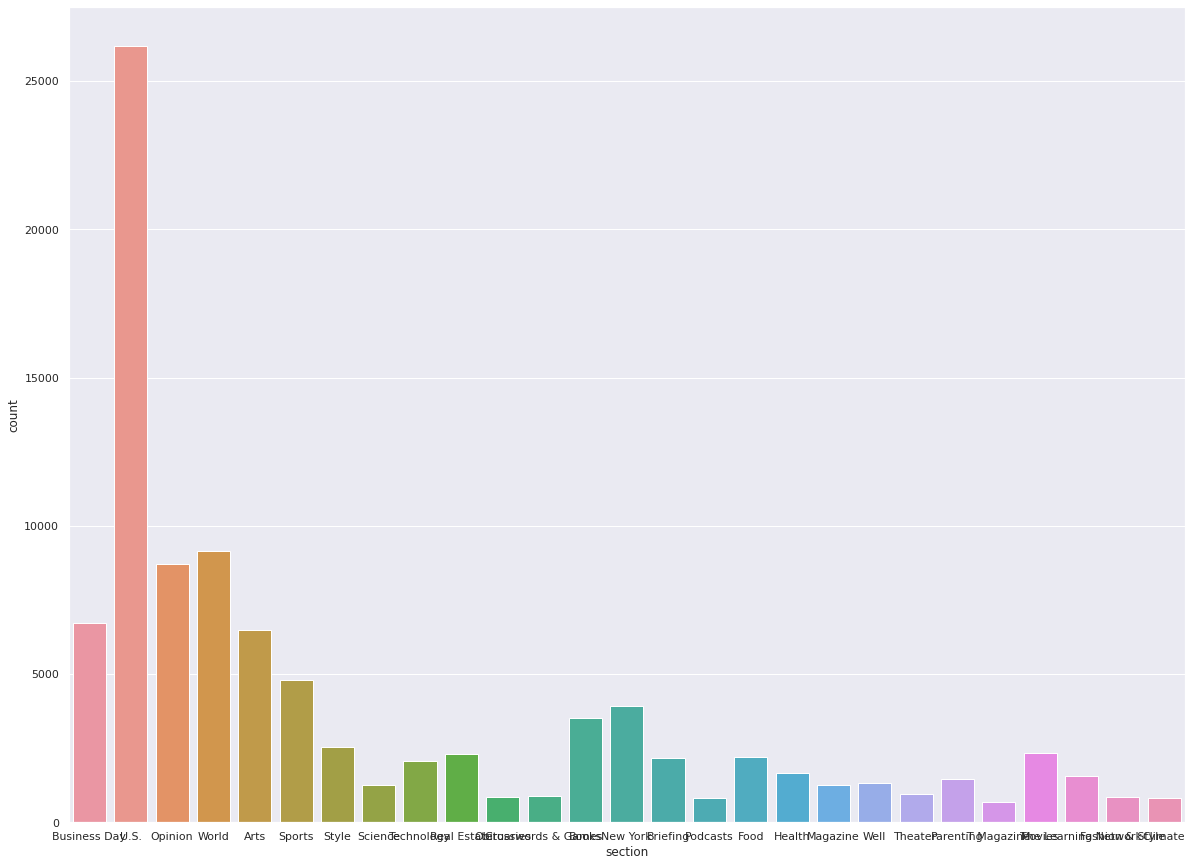

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
sns.countplot(data.section)

In [ ]:
data['news_length'] = data['headline'].str.len() + data['abstract'].str.len() + data['lead_paragraph'].str.len() + data['keywords'].str.len()
data['news_length']

0         686
1         547
2         428
3         445
6         786
         ... 
106605    458
106606    559
106607    617
106608    632
106609    513
Name: news_length, Length: 97456, dtype: int64

In [ ]:
data['text'] = data['headline'] + data['abstract'] + data['lead_paragraph'] + data['keywords']
data['text'][0]

'A Better Year for Trump’s Family Business (Last Year, That Is)In 2019, the Trump Organization showed improvement over the previous year. But the company’s minimum reported revenues still fell short of the president’s first year in office, his new financial disclosure shows.Before the coronavirus ripped through the country, upending President Trump’s family business and the broader hospitality industry, the company last year showed modest gains, according to Mr. Trump’s annual financial disclosure report released late Friday.Coronavirus (2019-nCoV),Hotels and Travel Lodgings,United States Politics and Government,Shutdowns (Institutional),Real Estate (Commercial),Company Reports,'

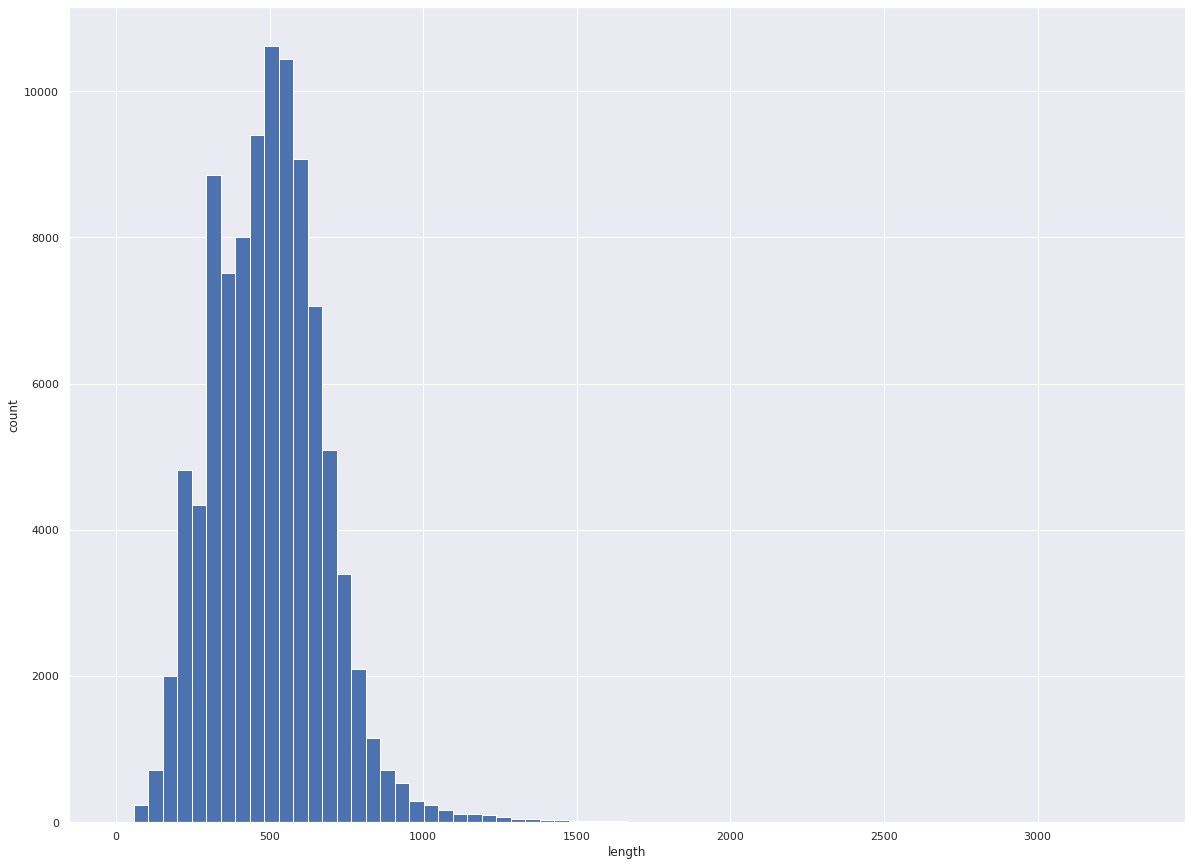

In [ ]:
sns.set()
_ =plt.hist(data['news_length'],bins=70)
_= plt.xlabel("length")
_=plt.ylabel("count")
plt.show()

************************************************************ Business Day *********************************************************


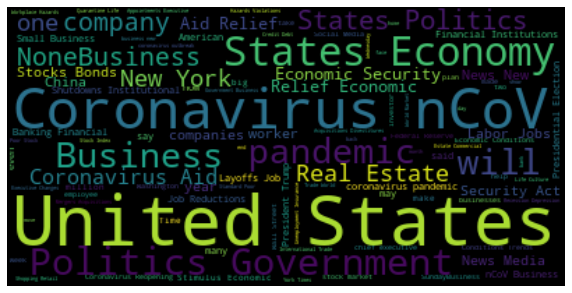

************************************************************ U.S. *********************************************************


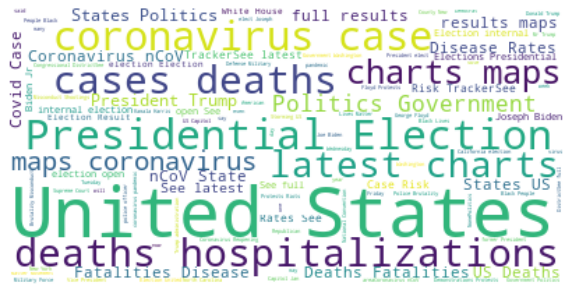

************************************************************ Opinion *********************************************************


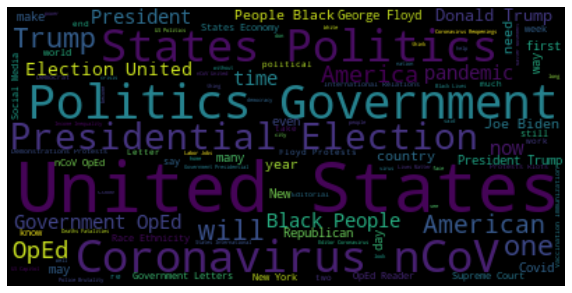

************************************************************ World *********************************************************


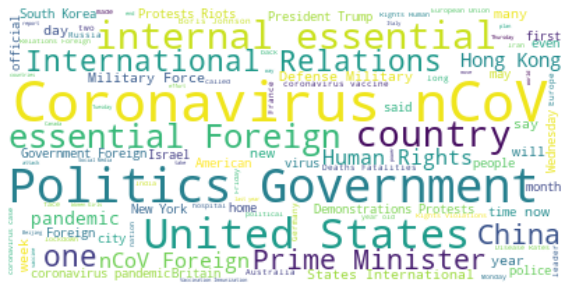

************************************************************ Arts *********************************************************


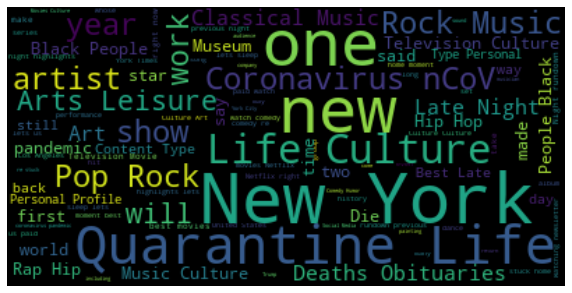

************************************************************ Sports *********************************************************


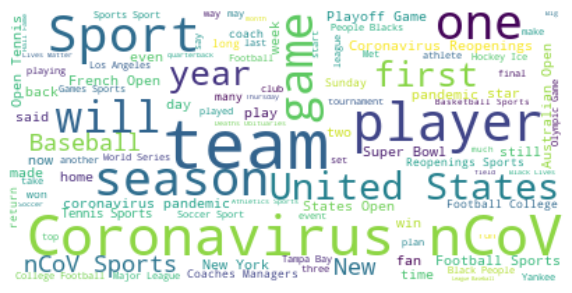

************************************************************ Style *********************************************************


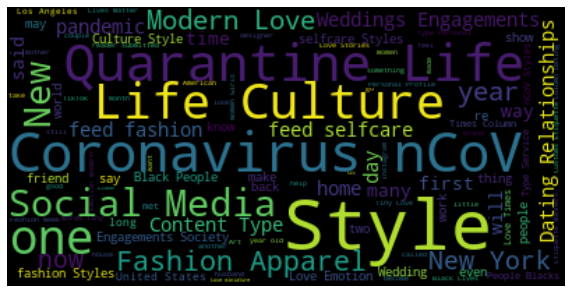

************************************************************ Science *********************************************************


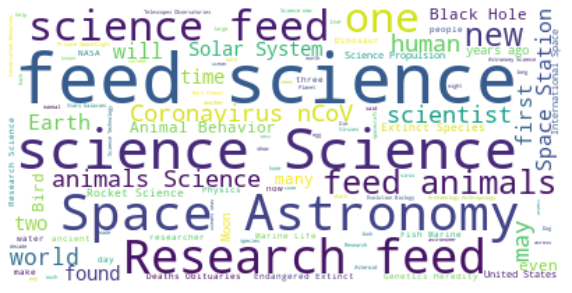

************************************************************ Technology *********************************************************


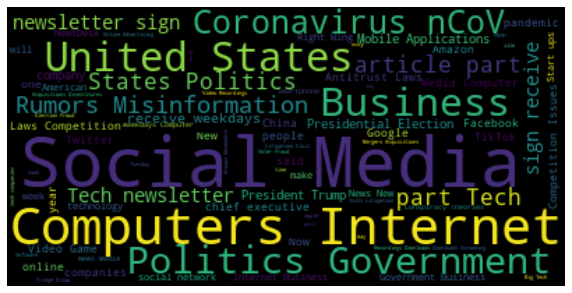

************************************************************ Real Estate *********************************************************


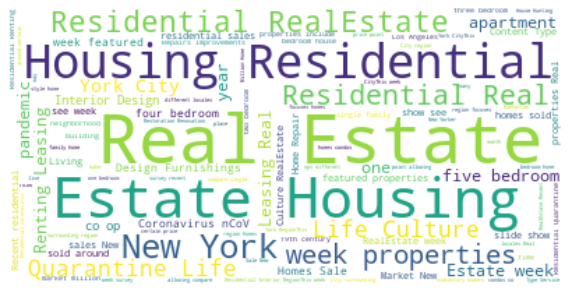

************************************************************ Obituaries *********************************************************


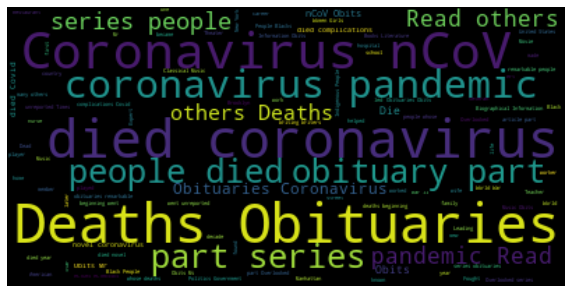

************************************************************ Crosswords & Games *********************************************************


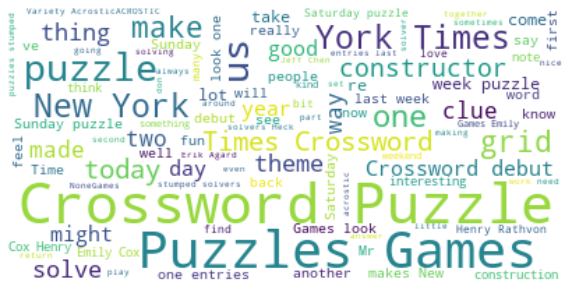

************************************************************ Books *********************************************************


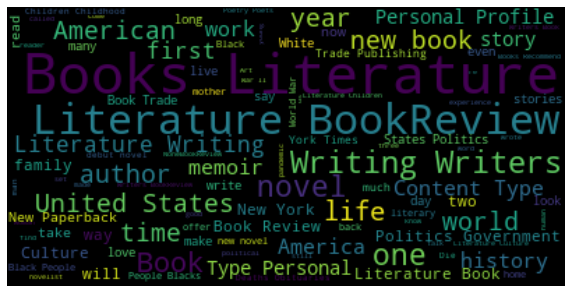

************************************************************ New York *********************************************************


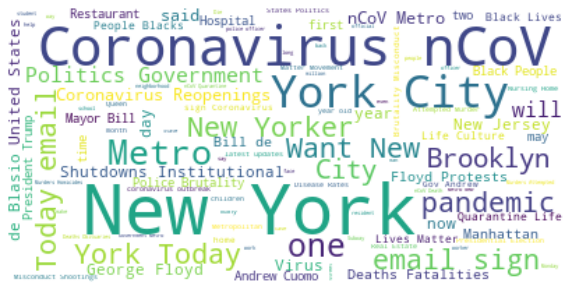

************************************************************ Briefing *********************************************************


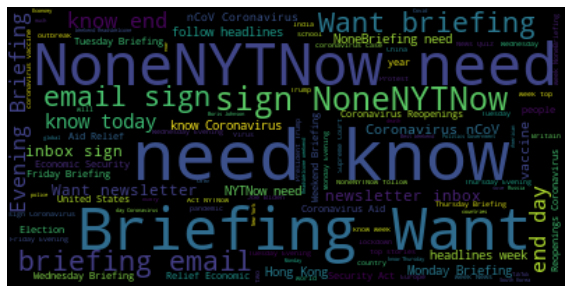

************************************************************ Podcasts *********************************************************


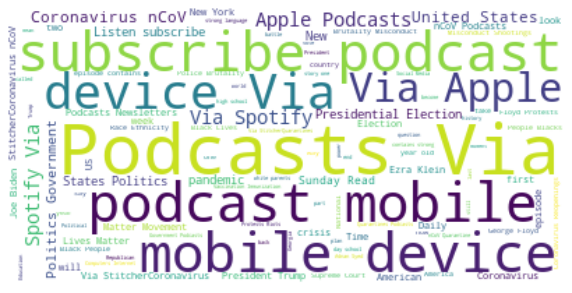

************************************************************ Food *********************************************************


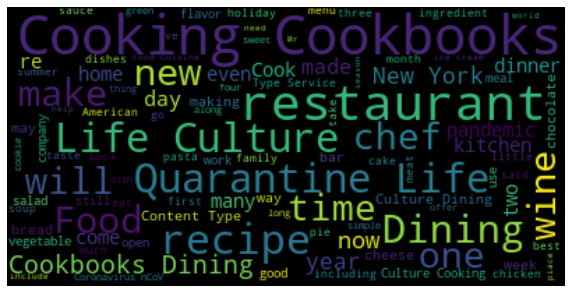

************************************************************ Health *********************************************************


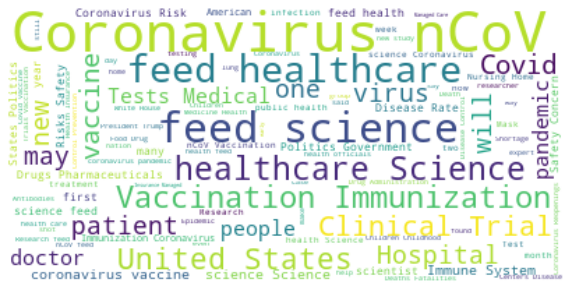

************************************************************ Magazine *********************************************************


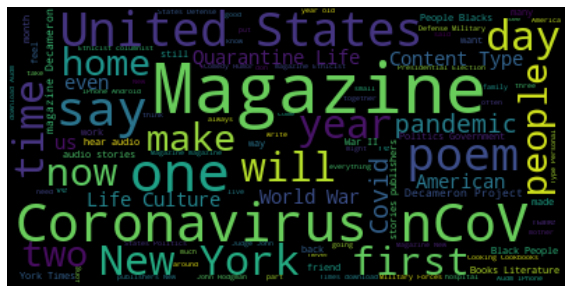

************************************************************ Well *********************************************************


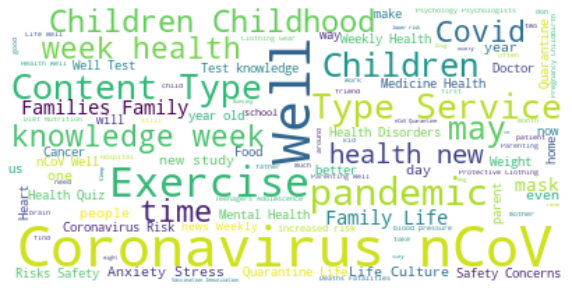

************************************************************ Theater *********************************************************


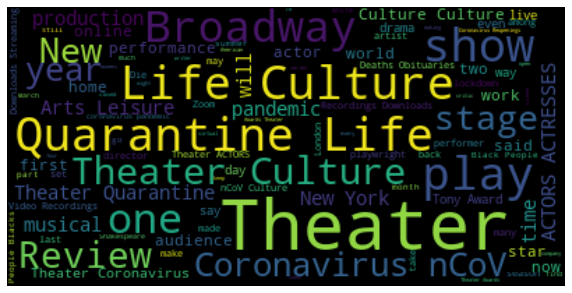

************************************************************ Parenting *********************************************************


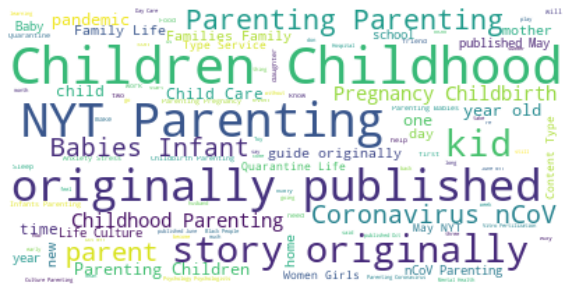

************************************************************ T Magazine *********************************************************


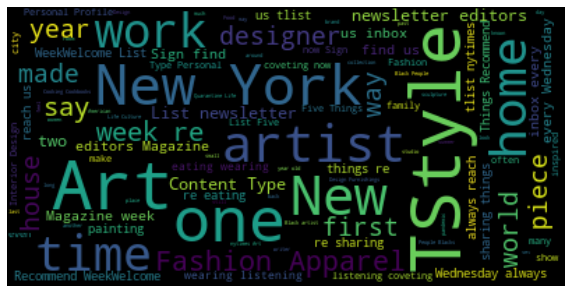

************************************************************ Movies *********************************************************


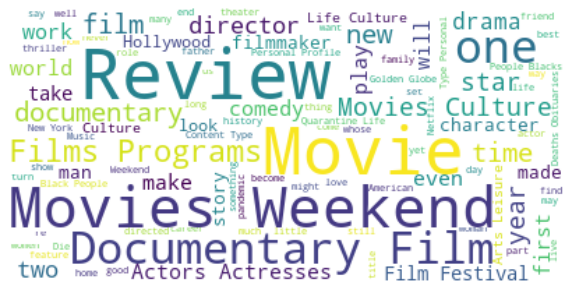

************************************************************ The Learning Network *********************************************************


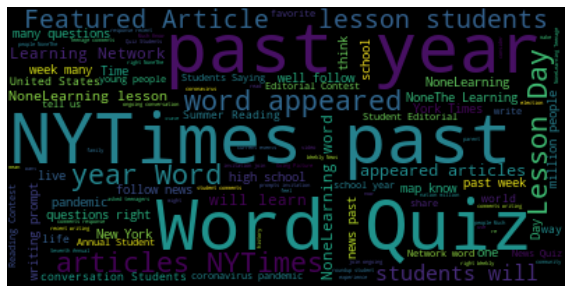

************************************************************ Fashion & Style *********************************************************


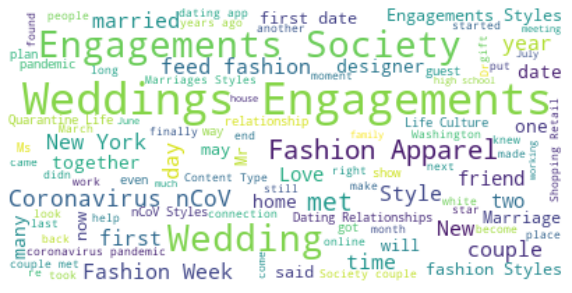

************************************************************ Climate *********************************************************


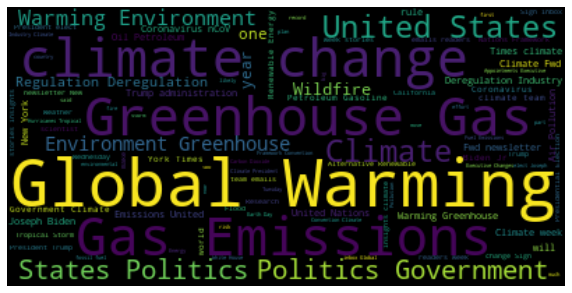

In [ ]:

categories = data['section'].unique()
i = 1
for category in categories:
  subset = data[data.section == category]
  sns.set(rc={'figure.figsize':(10,8)})
  text = subset.abstract.values + subset.headline.values + subset.lead_paragraph.values + subset.keywords.values + subset.news_desk.values
  word = ' '.join(text)
  print('************************************************************',category,'*********************************************************')
  if (i % 2==0):
    word_cloud(word,'white')
  else:
    word_cloud(word,'black')
  i = i+1



In [ ]:
data['parsed_text'] = data['text'].apply(preprocess_text)
data['parsed_text'] = data['parsed_text'].apply(tokenize_stopwords)
data.head()

headline  ...                                        parsed_text
0  A Better Year for Trump’s Family Business (Las...  ...  better year trumps family business last year i...
1  Court Frees Michigan Teen Who Was Held for Ski...  ...  court frees michigan teen held skipping online...
2            Federal Agents Don’t Need Army Fatigues  ...  federal agents dont need army fatiguesif youre...
3  Canada’s Key Role in Creating a Once Awaited V...  ...  canadas key role creating awaited vaccinean am...
6  What’s on TV Saturday: ‘Seeing America With Me...  ...  whats tv saturday seeing america megan rapinoe...

[5 rows x 13 columns]

In [ ]:
#label encoding
label_encoder = preprocessing.LabelEncoder()
data['section_encoded'] = label_encoder.fit_transform(data['section'])
data

headline  ... section_encoded
0       A Better Year for Trump’s Family Business (Las...  ...               3
1       Court Frees Michigan Teen Who Was Held for Ski...  ...              24
2                 Federal Agents Don’t Need Army Fatigues  ...              13
3       Canada’s Key Role in Creating a Once Awaited V...  ...              26
6       What’s on TV Saturday: ‘Seeing America With Me...  ...               0
...                                                   ...  ...             ...
106605  Supreme Court Lets Trump Keep Building His Bor...  ...              24
106606  The Coronavirus Infected Hundreds at a Georgia...  ...               8
106607  Trump’s Coronavirus Testing Chief Concedes a L...  ...              24
106608  White House and Congress Clash on Relief Plan ...  ...              24
106609      The Less Impossible Israeli-Palestinian Peace  ...              13

[97456 rows x 14 columns]

In [ ]:
#splitting data into test & train
X_train, X_test, y_train,y_test = train_test_split(data['parsed_text'],data['section_encoded'],test_size = 0.2,random_state=8)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(77964,)
(77964,)
(19492,)
(19492,)


In [ ]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 3000

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range = ngram_range,
                        stop_words = None,
                        lowercase = False,
                        max_df = max_df,
                        min_df = min_df,
                        max_features = max_features,
                        norm = 'l2',
                        sublinear_tf = True
                        )
train_features = tfidf.fit_transform(X_train).toarray()
train_label = y_train

test_features = tfidf.transform(X_test).toarray()
test_label = y_test

In [ ]:
print(test_label.shape)
print(train_label.shape)
print(train_features.shape)
print(test_features.shape)


(19492,)
(77964,)
(77964, 3000)
(19492, 3000)


# Implementing the machine learning model

In [ ]:
model = RandomForestClassifier()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

0.9381284629591627
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1277
           1       0.95      0.93      0.94       708
           2       1.00      0.95      0.97       461
           3       0.93      0.90      0.92      1310
           4       0.94      0.90      0.92       147
           5       0.98      1.00      0.99       171
           6       0.95      0.90      0.92       158
           7       0.93      0.96      0.95       415
           8       0.96      0.86      0.90       333
           9       0.98      0.91      0.94       257
          10       0.92      0.96      0.94       465
          11       0.95      0.91      0.93       852
          12       0.97      0.92      0.95       159
          13       0.93      0.89      0.91      1708
          14       0.97      0.94      0.96       275
          15       1.00      0.88      0.94       185
          16       0.98      1.00      0.99       453
        

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))
print(predictions)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7716499076544223
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1277
           1       0.83      0.79      0.81       708
           2       0.97      0.84      0.90       461
           3       0.71      0.68      0.70      1310
           4       0.81      0.59      0.68       147
           5       0.97      0.98      0.97       171
           6       0.78      0.55      0.65       158
           7       0.81      0.83      0.82       415
           8       0.59      0.47      0.53       333
           9       0.86      0.42      0.56       257
          10       0.79      0.79      0.79       465
          11       0.79      0.75      0.77       852
          12       0.84      0.78      0.81       159
          13       0.61      0.65      0.63      1708
          14       0.84      0.76      0.79       275
          15       0.96      0.55      0.70       185
          16       0.93      0.96      0.95       453
        

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))

In [ ]:
print(predictions)

[24 26 18 ... 13  8 18]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))


0.9145290375538683
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1277
           1       0.92      0.93      0.92       708
           2       0.96      0.94      0.95       461
           3       0.87      0.87      0.87      1310
           4       0.91      0.92      0.91       147
           5       0.99      0.99      0.99       171
           6       0.91      0.86      0.88       158
           7       0.89      0.91      0.90       415
           8       0.90      0.84      0.87       333
           9       0.91      0.90      0.90       257
          10       0.93      0.92      0.93       465
          11       0.94      0.88      0.91       852
          12       0.95      0.90      0.92       159
          13       0.87      0.88      0.87      1708
          14       0.90      0.93      0.91       275
          15       0.90      0.89      0.90       185
          16       0.98      0.98      0.98       453
        

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(train_features,train_label)
predictions = model.predict(test_features)
print(accuracy_score(test_label,predictions))
print(classification_report(test_label,predictions))
print(predictions)

0.4260209316642725
              precision    recall  f1-score   support

           0       0.82      0.18      0.30      1277
           1       0.38      0.27      0.32       708
           2       0.55      0.87      0.67       461
           3       0.53      0.28      0.37      1310
           4       0.23      0.85      0.36       147
           5       0.39      0.82      0.53       171
           6       0.23      0.78      0.36       158
           7       0.32      0.52      0.40       415
           8       0.17      0.46      0.25       333
           9       0.14      0.39      0.20       257
          10       0.24      0.60      0.34       465
          11       0.40      0.44      0.42       852
          12       0.46      0.81      0.59       159
          13       0.42      0.15      0.22      1708
          14       0.41      0.77      0.53       275
          15       0.28      0.83      0.41       185
          16       0.63      0.86      0.73       453
        